In [1]:
from pathlib import Path
import json
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

from scripts.dataset.dataloader import SemEvalTask8, collate_fn
from scripts.models.lstmer import LSTMER

from scripts.utils.test_utils import get_predictions, decode_vocab
from scripts.utils.test_utils import write_results, calculate_scores
from scripts.utils.utils import seed_everything, plot_bar
from scripts.utils.gpu_cuda_helper import select_device

import warnings
from dgl.base import DGLWarning

warnings.simplefilter("ignore", DGLWarning)


In [2]:
seed = 9001
seed_everything(seed)


In [3]:
ds_dir = "dataset/semeval_task8/processed/"
tree_type = ["shortest_path", "full_tree"]
config_path = "scripts/config.json"
checkpoints_dir = Path("/srv/data/zarzouram/lt2011/checkpoints/")
answer_dir = Path("dataset/semeval_task8/processed/").resolve().expanduser()
answer_keys_path = Path(
    "dataset/semeval_task8/processed/answer_keys.txt").resolve().expanduser()
scorer_path = Path(
    "dataset/semeval_task8/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl"  # noqa: E501
).resolve().expanduser()  # noqa: E501

checkpoints = {
    tree_type[0]: str(checkpoints_dir / "1005.0200/checkpoint_best.pth.tar"),
    tree_type[1]: str(checkpoints_dir / "1005.0359/checkpoint_best.pth.tar")
}


In [4]:
train_data = torch.load(Path(ds_dir) / "raw_train.pt")
val_data = torch.load(Path(ds_dir) / "raw_val.pt")
test_data = torch.load(Path(ds_dir) / "raw_test.pt")

_, _, ents_trn, _, dep_trn, _, _, _, _, rel_trn, dir_trn = train_data
_, _, ents_val, _, dep_val, _, _, _, _, rel_val, dir_val = val_data
_, _, ents_tst, _, dep_tst, _, _, _, _, rel_tst, dir_tst = test_data


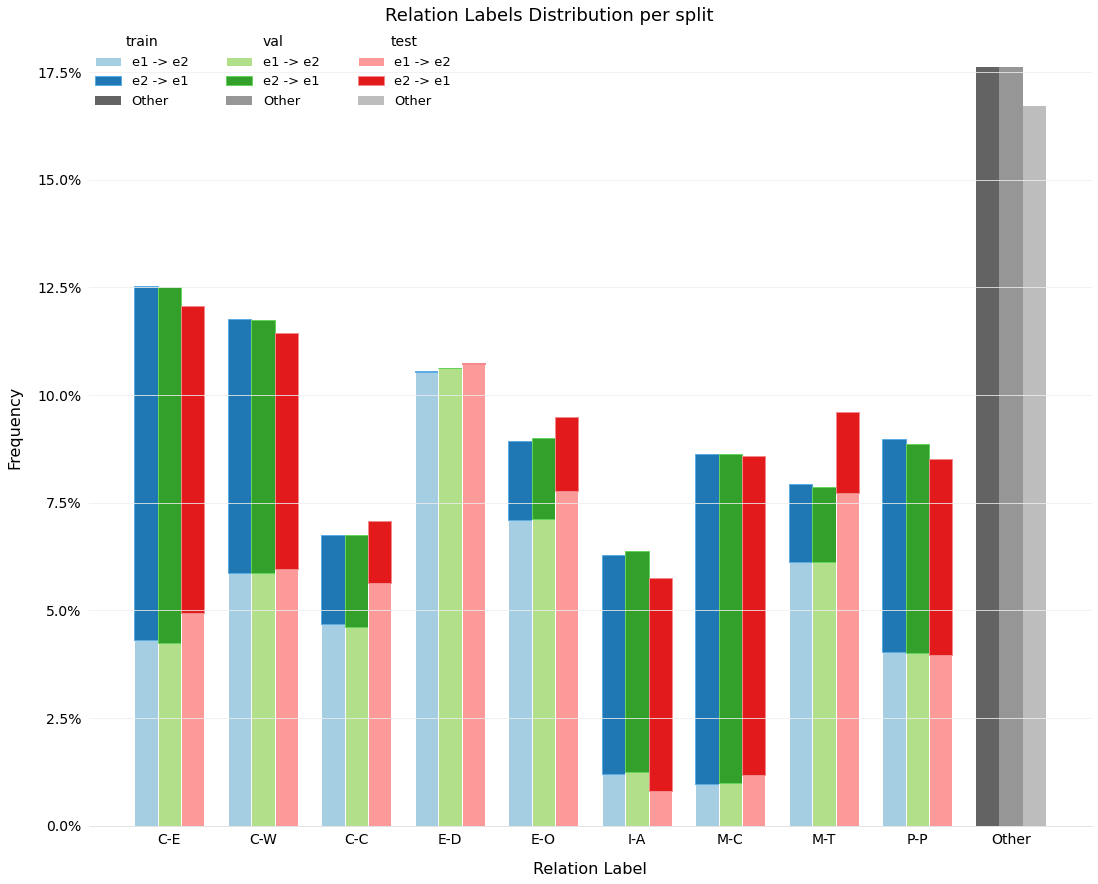

In [5]:
_ = plot_bar(rel=[rel_trn, rel_val, rel_tst], dir=[dir_trn, dir_val, dir_tst])


In [6]:
vocabs = torch.load(Path(ds_dir) / "vocabs.pt")
pad_values = {
    "token_pad_value": vocabs["tokens"]["<pad>"],
    "pos_pad_value": vocabs["pos"]["<pad>"],
    "dep_pad_value": vocabs["dep"]["<pad>"],
    "entl_pad_value": vocabs["ents"]["<pad>"]
}
vocab_sizes = {
    "token_vocab_sz": len(vocabs["tokens"]),
    "pos_vocab_sz": len(vocabs["pos"]),
    "dep_vocab_sz": len(vocabs["dep"]),
    "entl_vocab_sz": len(vocabs["ents"]),
    "rel_num": len(vocabs["rels"])
}

test_ds = SemEvalTask8(Path(ds_dir) / "test.pt")


In [7]:
device = select_device("gpu")
print(f"selected device is {device}.\n")



 cuda id   Memory usage  
    0          0.02%     
    1          0.02%     
    2          7.83%     
    3          0.02%     
selected device is cuda:3.



In [8]:
# load confuguration file
with open(config_path, "r") as f:
    config = json.load(f)
e1_tag = config["dataset"]["tags"]["ent"]["e1"]
e2_tag = config["dataset"]["tags"]["ent"]["e2"]
es_tag = [vocabs["ents"][e1_tag], vocabs["ents"][e2_tag]]


In [9]:
results = {}
neg_rel = vocabs["rels"]["Other"]
dir_ids = [
    vocabs["rel_dir"]["ndir"], vocabs["rel_dir"]["(e1,e2)"],
    vocabs["rel_dir"]["(e2,e1)"]
]
for t_type, path in checkpoints.items():

    data_loader = DataLoader(test_ds,
                             batch_size=1,
                             shuffle=False,
                             num_workers=4,
                             collate_fn=collate_fn(list(pad_values.values()),
                                                   t_type))

    model_hyp = config["model_hyperp"]
    model_hyp["dep_tree"]["tree_type"] = t_type
    model = LSTMER(**vocab_sizes,
                   **pad_values,
                   **model_hyp["embeddings"],
                   **model_hyp["entity_detect"],
                   **model_hyp["dep_tree"],
                   **model_hyp["rel_extract"],
                   **model_hyp["modes"],
                   dropouts=model_hyp["dropouts"])

    # load checkpoint
    state = torch.load(path, map_location=torch.device("cpu"))
    model.load_state_dict(state["model"])
    model = model.to(device)

    model.eval()
    pb = tqdm(data_loader, total=len(data_loader), unit="step")
    ids = []
    rel_allpreds, dir_allpreds = [], []
    rel_alltargets, dir_alltargets = [], []
    for step, batch in enumerate(pb):
        # set progress bar description and metrics
        pb.set_description(f"Tree Type: {t_type}")
        with torch.no_grad():
            # move data to device
            batch = [b.to(device) for b in batch]
            logits_12, logits_21, *_ = model(batch, es_tag)
            rel_preds, dir_preds = get_predictions(logits_12, logits_21,
                                                   neg_rel, dir_ids)
            rel_targets, dir_targets = batch[-2:]
            ids.append(batch[0])
            rel_allpreds.append(rel_preds)
            dir_allpreds.append(dir_preds)
            rel_alltargets.append(rel_targets)
            dir_alltargets.append(dir_targets)

    ids = torch.cat(ids).tolist()
    rel_allpreds = torch.cat(rel_allpreds).tolist()
    dir_allpreds = torch.cat(dir_allpreds).tolist()

    rel_preds_str = decode_vocab(vocabs["rels"], rel_allpreds)
    dir_preds_str = decode_vocab(vocabs["rel_dir"], dir_allpreds)

    answer_path = str(answer_dir / f"{t_type}_answers.txt")
    write_results(ids, rel_preds_str, dir_preds_str, answer_path)
    p, r, f1, acc, scores, result = calculate_scores(str(scorer_path),
                                                     answer_path,
                                                     str(answer_keys_path))

    results[t_type] = {
        "f1": f1,
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "scores": scores,
        "result": result
    }

  0%|          | 0/2716 [00:00<?, ?step/s]

  0%|          | 0/2716 [00:00<?, ?step/s]

In [10]:
for t_type in results:
    print(f"{t_type:15s}: f1_score: {results[t_type]['f1']:.2f}%, Precision: {results[t_type]['precision']}%, Recall: {results[t_type]['recall']}%")

shortest_path  : f1_score: 76.30%, Precision: 76.52%, Recall: 76.35%
full_tree      : f1_score: 75.26%, Precision: 75.79%, Recall: 75.07%


In [11]:
from IPython.display import display
import pandas as pd

labels = results["full_tree"]["scores"].keys()
scores = {
    label: {
        ("p", t): 0,
        ("r", t): 0,
        ("f1", t): 0
    }
    for label in labels for t in results.keys()
}
for t_type, scores_dict in results.items():
    for label, (p, r, f) in scores_dict["scores"].items():
        scores[label][("p", t_type)] = p
        scores[label][("r", t_type)] = r
        scores[label][("f1", t_type)] = f

scores_new = {}
for label, scores_dict in scores.items():
    keys_sorted = sorted(list(scores_dict.keys()), key=lambda x: x[0])
    scores_dict_sorted = {k: scores_dict[k] for k in keys_sorted}
    scores_new[label] = scores_dict_sorted

df = pd.DataFrame.from_dict(scores_new, orient="index")
display(df)


f1                       p                       r  \
                   full_tree shortest_path full_tree shortest_path full_tree   
Cause-Effect           84.24         87.38     86.26         90.52     82.32   
Component-Whole        71.36         68.50     71.02         68.83     71.70   
Content-Container      80.58         83.13     75.45         78.34     86.46   
Entity-Destination     85.23         86.45     83.55         81.71     86.99   
Entity-Origin          82.40         78.75     79.71         79.22     85.27   
Instrument-Agency      56.34         63.95     62.50         68.12     51.28   
Member-Collection      77.61         79.75     77.12         77.64     78.11   
Message-Topic          74.07         73.60     80.00         76.99     68.97   
Product-Producer       65.49         65.18     66.52         67.28     64.50   
_Other                 39.57         36.68     38.66         36.36     40.53   

                                  
                   shortest_path  
Cause-Effect               84.45  
Component-Whole            68.17  
Content-Container          88.54  
Entity-Destination         91.78  
Entity-Origin              78.29  
Instrument-Agency          60.26  
Member-Collection          81.97  
Message-Topic              70.50  
Product-Producer           63.20  
_Other                     37.00

In [31]:
print("\n".join(results["full_tree"]["result"].strip().split("\n")[:15]))

Confusion matrix:
         C-E  C-W  C-C  E-D  E-O  I-A  M-C  M-T  P-P  _O_ <-- classified as
      +--------------------------------------------------+ -SUM- xDIRx skip  ACTUAL
  C-E | 270    1    1    1   12    0    0    0    7   33 |  325     3     0    328
  C-W |   3  223    5    0    2    6   14    6    5   44 |  308     3     0    311
  C-C |   0    5  166    7    3    1    0    1    0    8 |  191     1     0    192
  E-D |   1    3    9  254    0    1    0    2    1   21 |  292     0     0    292
  E-O |   5    3    0    3  220    1    0    1    2   23 |  258     0     0    258
  I-A |   4   17    2    1    3   80    1    1   12   33 |  154     2     0    156
  M-C |   2    6    0    1    2    1  182    1    4   33 |  232     1     0    233
  M-T |   0    5    3    2    1    3    2  180    7   58 |  261     0     0    261
  P-P |   8    8    1    2    4   11    3    3  149   39 |  228     3     0    231
  _O_ |  17   40   32   33   29   22   33   30   34  184 |  454     0     0

In [32]:
print("\n".join(results["shortest_path"]["result"].strip().split("\n")[:15]))

Confusion matrix:
         C-E  C-W  C-C  E-D  E-O  I-A  M-C  M-T  P-P  _O_ <-- classified as
      +--------------------------------------------------+ -SUM- xDIRx skip  ACTUAL
  C-E | 277    3    0    1    6    0    0    3    5   32 |  327     1     0    328
  C-W |   1  212    5    2    4   11   11    6    4   53 |  309     2     0    311
  C-C |   0    1  170    3    2    1    1    1    0    9 |  188     4     0    192
  E-D |   0    1    7  268    0    0    0    1    1   13 |  291     1     0    292
  E-O |   6    4    1    4  202    0    0    1    3   37 |  258     0     0    258
  I-A |   0   12    0    3    4   94    0    1   13   29 |  156     0     0    156
  M-C |   0   10    0    0    1    0  191    1    3   26 |  232     1     0    233
  M-T |   0    7    4    3    2    2    2  184    5   51 |  260     1     0    261
  P-P |   5    9    1    2    6    9    3    3  146   44 |  228     3     0    231
  _O_ |  16   47   25   41   28   21   37   37   34  168 |  454     0     0